# Solving for temperature in a PCB trace

Here we show how alternating invocations of a trivial Poisson solver suffice to do a primitive "multi-physics" simulation of current and temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Recall that the inhomogeneous heat equation has the form:
$$ \partial_t u = k \nabla^2 u + q $$
for some temperature distribution $u : \mathbb{R}^3 \to \mathbb{R}$, thermal conductivity $k : \mathbb{R^3} \to \mathbb{R}$, and some source term $q: \mathbb{R}^3 \to \mathbb{R}$.
To find the steady-state solution, we set $\partial_u = 0$, getting $\nabla^2 u = -q / k$, which is a Poisson equation.
Therefore, we write the world's simplest Poisson solver.

In [2]:
interior_2d = slice(1, -1), slice(1, -1)
interior_3d = slice(1, -1), slice(1, -1), slice(1, -1)

def laplacian_2d(a):
    b = np.zeros_like(a)
    b[interior_2d] = (
        a[:-2, 1:-1] + a[2:, 1:-1]
        + a[1:-1, :-2] + a[1:-1, 2:]
        - 4*a[interior_2d]
    ) / 4
    return b

def laplacian_3d(a):
    b = np.zeros_like(a)
    b[interior_3d] = (
        a[:-2, 1:-1, 1:-1] + a[2:, 1:-1, 1:-1]
        + a[1:-1, :-2, 1:-1] + a[1:-1, 2:, 1:-1]
        + a[1:-1, 1:-1, :-2] + a[1:-1, 1:-1, 2:]
        - 6*a[interior_3d]
    ) / 6
    return b

def poisson_solve(initial, f, bc_mask, max_iters=1000, tol=1e-5):
    """
    poisson_solve(initial, f, max_iters=10) -> u
    Returns `u` such that ∇²u = f in the interior, and `u` agrees
    with `initial` wherever bc_mask is one (Dirichlet boundary conditions).
    """
    u, f = np.asarray(initial), np.asarray(f)
    assert u.shape == f.shape
    for iteration in range(max_iters):
        # Take a step. (no successive over-relaxation here, just a trivial update)
        if len(u.shape) == 2:
            error = np.where(bc_mask[interior_2d], 0, (laplacian_2d(u)[interior_2d] - f[interior_2d]))
            u[interior_2d] += error
        else:
            error = np.where(bc_mask[interior_3d], 0, (laplacian_3d(u)[interior_3d] - f[interior_3d]))
            u[interior_3d] += error
        # Check for convergence.
        error = np.max(np.abs(error))
        if error <= tol:
            print(f"Converged in {iteration} iterations.")
            return u
    print("Failed to converge -- remaining max error:", error)
    return u

Using this Poisson solver, let's now find the steady-state temperature distribution in a 2D plate whose four edges are held at a temperature of 0, and which is being heated throughout.
This corresponds to setting $q = 1$ everywhere inside of the plate, and $k = 1$ everywhere (as the plate is homogenous).
Therefore, we seek a solution to $\nabla^2 u = -q/k = -1$.

Converged in 9644 iterations.


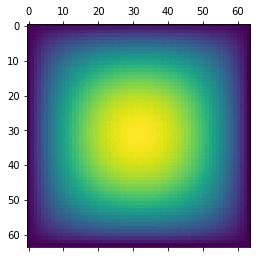

In [3]:
# Let's now find the steady-state temperature in a plate whose edges
# are held at 0, and which is being heated uniformly throughout.
r = poisson_solve(
    initial=np.zeros((64, 64)),
    f=-np.ones((64, 64)),
    bc_mask=np.pad(np.zeros((62, 62)), 1, constant_values=1),
    max_iters=10_000,
    tol=1e-5,
)
plt.matshow(r)

Sure enough, the above looks like a reasonable solution — the plate is warm in the middle, and gets cooler towards the edges.

Now let's find the steady-state current distribution of some setup, by solving for the voltage distribution.
We know the following:
* The E-field is given by $\vec{E} = \nabla V$ by definition.
* The current density $\vec{J} = \sigma \vec{E}$, per Ohm's law.
* Kirchoff's current law tells us $\nabla \cdot \vec{J} = 0$, but if we have external current sources or sinks we get $\nabla \cdot \vec{J} = s$, for some source term $s$.

Putting this all together for some spatially varying conductivity $\sigma : \mathbb{R}^3 \to \mathbb{R}$, we get:
\begin{align*}
    \nabla \cdot \vec{J} &= s\\
    \nabla \cdot (\sigma \vec{E}) &= \\
    \nabla \cdot (\sigma \nabla V) &= \\
    \sigma \nabla^2 V + (\nabla \sigma) \cdot (\nabla V) &= \\
    \nabla^2 V &= \frac{s - (\nabla \sigma) \cdot (\nabla V)}{\sigma}
\end{align*}

In the speical case where $\sigma$ isn't spatially varying, the $(\nabla \sigma) \cdot (\nabla V)$ term vanishes, and this becomes another Poisson equation!
Unfortunately, we care about the case where $\sigma$ varies, as that's the case that lets us actually model a trace (a region of higher conductivity),

Note that this equation ends up somewhat ill-conditioned for resistive materials, as then $\sigma$ ends up nearly equal to zero, and therefore the RHS blows up.
This makes sense intuitively — even a tiny source current $s$ results in absolutely massive voltages in a resistive material.
If you could continuously dump 1 mA into the middle of block of rubber, things would get very exciting very quickly!
Therefore, we will have to be very careful about how we set boundary conditions when solving for voltages.

Let's now solve for the current in a little trace shape.

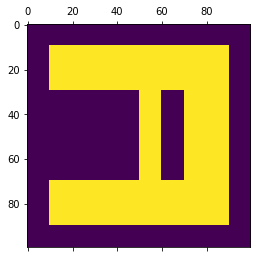

In [4]:
# Here's what our trace looks like.
trace_mask = np.zeros((100, 100))
trace_mask[10:30, 10:90] = 1
trace_mask[70:90, 10:90] = 1
trace_mask[10:90, 70:90] = 1
trace_mask[10:90, 50:60] = 1
plt.matshow(trace_mask)

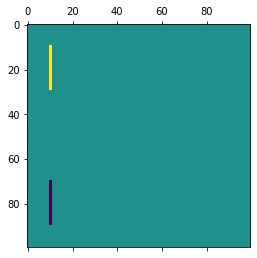

In [5]:
# Let's define the current source and sink term, adding current at the top left, and removing it at the bottom left.
source = np.zeros((100, 100))
source[10:30, 10] = 1
source[70:90, 10] = -1
plt.matshow(source)

In [25]:
# Let's now solve for voltage everywhere.
def grad_2d(a):
    grad = np.zeros((2, *a.shape))
    grad[0][interior_2d] = (a[2:, 1:-1] - a[:-2, 1:-1]) / 2
    grad[1][interior_2d] = (a[1:-1, 2:] - a[1:-1, :-2]) / 2
    return grad

def grad_3d(a):
    grad = np.zeros((3, *a.shape))
    grad[0][interior_3d] = (a[2:, 1:-1, 1:-1] - a[:-2, 1:-1, 1:-1]) / 2
    grad[1][interior_3d] = (a[1:-1, 2:, 1:-1] - a[1:-1, :-2, 1:-1]) / 2
    grad[2][interior_3d] = (a[1:-1, 1:-1, 2:] - a[1:-1, 1:-1, :-2]) / 2
    return grad

def divergence_2d(a):
    assert a.shape[0] == 2
    x_term = a[0][2:, 1:-1] - a[0][:-2, 1:-1]
    y_term = a[1][1:-1, 2:] - a[1][1:-1, :-2]
    return x_term + y_term

def divergence_3d(a):
    assert a.shape[0] == 3
    x_term = a[0][2:, 1:-1, 1:-1] - a[0][:-2, 1:-1, 1:-1]
    y_term = a[1][1:-1, 2:, 1:-1] - a[1][1:-1, :-2, 1:-1]
    z_term = a[2][1:-1, 1:-1, 2:] - a[2][1:-1, 1:-1, :-2]
    return x_term + y_term + z_term

def dot_product(a, b):
    return np.sum(a * b, axis=0)

def voltage_solve(current_sources, sigma, step_size=0.1, max_iters=1000, tol=1e-5):
    assert current_sources.shape == sigma.shape
    voltage = np.zeros_like(sigma)
    grad_sigma = grad_2d(sigma)
    for iteration in range(max_iters):
        # Take a step. (no successive over-relaxation here, just a trivial update)
        if len(voltage.shape) == 2:
            rhs = (current_sources - dot_product(grad_sigma, grad_2d(voltage))) / sigma
            error = laplacian_2d(voltage)[interior_2d] - rhs[interior_2d]
            voltage[interior_2d] += step_size * error
        else:
            rhs = (current_sources - dot_product(grad_sigma, grad_3d(voltage))) / sigma
            error = laplacian_3d(voltage)[interior_3d] - rhs[interior_3d]
            voltage[interior_3d] += step_size * error
        # Check for convergence.
        error = np.max(np.abs(error))
        if error <= tol:
            print(f"Converged in {iteration} iterations.")
            return voltage
    print("Failed to converge -- remaining max error:", error)
    return voltage

sigma = np.where(trace_mask, 1, 0.01)
voltage = voltage_solve(current_sources=source, sigma=sigma, max_iters=10_000, tol=1e-3)

Failed to converge -- remaining max error: 2.540868355843398e+78


In [47]:
def naive_voltage_solve(current_sources, sigma, step_size=0.2, max_iters=1000, tol=1e-3):
    assert current_sources.shape == sigma.shape
    voltage = np.zeros_like(sigma)
    for iteration in range(max_iters):
        current = sigma * grad_2d(voltage)
        divergence_error = current_sources.copy()
        if len(voltage.shape) == 2:
            divergence_error[interior_2d] -= divergence_2d(current)
        else:
            divergence_error[interior_3d] -= divergence_3d(current)
        voltage_error = laplacian_2d(voltage) - divergence_error
        voltage += step_size * voltage_error
        # Check for convergence.
        error = np.max(np.abs(divergence_error))
        if error <= tol:
            print(f"Converged in {iteration} iterations.")
            return voltage
    print("Failed to converge -- remaining max error:", error)
    return voltage

Failed to converge -- remaining max error: 0.6560956780922549


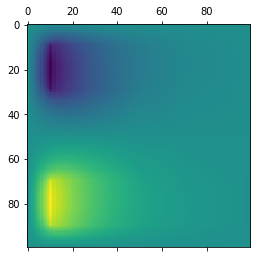

In [48]:
sigma = np.where(trace_mask, 1, 0.1)
voltage = naive_voltage_solve(current_sources=source, sigma=sigma, max_iters=100_000, tol=1e-3)
plt.matshow(voltage)

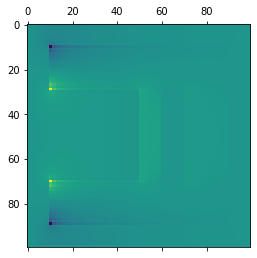

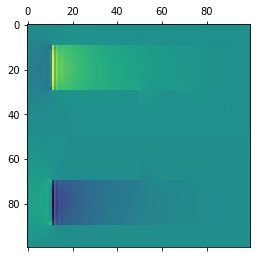

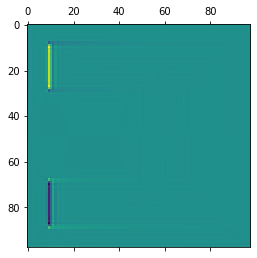

In [49]:
current = sigma * grad_2d(voltage)
plt.matshow(current[0])
plt.matshow(current[1])
plt.matshow(divergence_2d(current))